### Imports

In [1]:
from analyze_results import *
from getting_examples import *
from predict_activations import *
from model_utils import *
from utils import *
import json
import pprint

In [2]:
sae, model = load_sae_and_model()

/root/feature_benchmark/feat_bench/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
recompute_directory_activations('6-res-jb_subset_100', model, sae, recompute=False, re_sort=True)

2350.json sorted into 56 positive and 25 self_negative activations
23251.json sorted into 58 positive and 25 self_negative activations
11000.json sorted into 52 positive and 25 self_negative activations
13627.json sorted into 50 positive and 25 self_negative activations
21896.json sorted into 53 positive and 27 self_negative activations
6332.json sorted into 44 positive and 25 self_negative activations
2534.json sorted into 48 positive and 37 self_negative activations
11263.json sorted into 55 positive and 25 self_negative activations
8913.json sorted into 54 positive and 25 self_negative activations
9532.json sorted into 54 positive and 29 self_negative activations
5128.json sorted into 60 positive and 25 self_negative activations
5157.json sorted into 58 positive and 25 self_negative activations
15162.json sorted into 58 positive and 25 self_negative activations
12092.json sorted into 53 positive and 25 self_negative activations
19697.json sorted into 60 positive and 27 self_negative

In [3]:
feat_id = 1

description, pos_examples, neg_examples, highest_activation = get_pos_neg_examples(feat_id, layer=6, basis='res-jb', num_pos=2, num_neg=2, neg_type='others', randomize_pos_examples=False)
print(description)

max_indices = [pos_examples[i]['max_value_token_index'] + 1 for i in range(len(pos_examples))] + [9 for i in range(len(neg_examples))]
strings = [pos_examples[i]['sentence_string'] for i in range(len(pos_examples))] + [neg_examples[i]['sentence_string'] for i in range(len(neg_examples))]

for pos in pos_examples:
    print(pos['sentence_string'])
    print(pos['values'])

for neg in neg_examples:
    print(neg['sentence_string'])
    print(neg['values'])

mentions of financial funding through grants
 published this spring, was funded through a grant from NHTSA and conducted through the
[0, 0, 0, 0, 0, 0, 0, 0, 49.51050567626953, 0.1973066926002502, 0, 0, 0, 0, 0, 0, 0]
I. will receive a three-year grant from the Massachusetts Service Alliance that will place
[0, 0, 0, 0, 0, 0, 0, 0, 48.00002670288086, 0, 0, 0, 0, 0, 0, 0, 0]
 has devolved into a âĢľknife fight,âĢĿ writing on Twitter that he
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 but Orlando made it clear that if it flags again for whatever reason, Jefferson will find
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [4]:
pre_acts, inner_acts, post_acts = get_sae_activations(model, sae, strings)

for inner_act in inner_acts:
    x = np.array(inner_act)
    print(x[:,feat_id])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         48.49956131  1.33336258  0.
  0.          0.          0.          0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         42.76519775  0.          0.
  0.          0.          0.          0.          0.          0.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
# Get model's loss on strings
regular_losses = get_vanilla_loss(model, sae, strings)
print(pretty_losses_fmt("Regular", strings, regular_losses))

# Get model's loss on strings using SAE reconstructed activations
sae_losses = get_vanilla_loss(model, sae, strings, with_sae_replacement=True)
print(pretty_losses_fmt("SAE", strings, sae_losses))

# Loss with all features ablated
precomputed_zeros = [[[0.0] * len(l) for l in seq] for seq in inner_acts]
zeros_losses = get_recons_loss_from_predicted_values(model, sae, strings, precomputed_zeros)
print(pretty_losses_fmt("Zeros", strings, zeros_losses))

Regular losses:
 published this spring, was funded through a grant from NHTSA and conducted through the (4.1803): 13.6845 6.9317 6.7337 2.1646 5.5099 5.8693 3.7500 1.0739 2.1365 0.1572 6.3267 4.8857 0.0050 2.3500 5.8504 2.4335 1.2026
I. will receive a three-year grant from the Massachusetts Service Alliance that will place (4.7467): 3.9997 6.1135 11.2789 7.5890 1.7388 7.5961 0.6220 2.4118 5.1721 1.0106 0.4074 5.7994 9.1498 5.7121 3.7558 0.5996 7.7381
 has devolved into a âĢľknife fight,âĢĿ writing on Twitter that he (5.2934): 9.2262 9.6372 0.7124 0.4154 0.7375 13.1011 3.4074 6.8675 5.2687 2.0278 5.5630 14.7221 5.4033 2.3048 11.7609 3.5082 1.2562 0.5191 5.8215 12.7050 2.8637 3.5894 3.3287 2.2940
 but Orlando made it clear that if it flags again for whatever reason, Jefferson will find (5.1637): 9.4798 11.8629 6.9563 1.6820 1.4295 1.3284 3.9408 3.4473 11.8570 6.4385 3.4611 7.7009 0.2480 0.7260 10.1121 1.6435 5.4686
SAE losses:
 published this spring, was funded through a grant from NHTSA

Zeros losses:
 published this spring, was funded through a grant from NHTSA and conducted through the (8.6929): 9.7256 7.3141 10.6736 2.3919 7.9510 12.9913 5.9910 4.6239 10.9653 6.5388 10.9766 15.3514 19.6931 2.3378 9.0870 5.9910 5.1758
I. will receive a three-year grant from the Massachusetts Service Alliance that will place (9.3040): 12.6561 1.9816 8.2481 10.3467 4.6239 8.8132 6.0656 14.0043 10.9653 6.5388 5.1758 14.6507 13.7828 17.5590 5.6262 8.2481 8.8816
 has devolved into a âĢľknife fight,âĢĿ writing on Twitter that he (13.3899): 6.8246 9.6344 13.1302 7.5066 4.6239 12.0840 22.9173 16.9512 22.9173 16.9512 19.7396 21.1252 12.1505 2.3919 17.0953 16.9512 22.9173 16.9512 19.8813 11.2551 3.5308 9.3789 5.6262 8.8215
 but Orlando made it clear that if it flags again for whatever reason, Jefferson will find (8.4580): 6.8127 14.2523 6.8156 5.6377 10.0778 5.6262 8.4823 5.6377 13.4297 6.8230 4.9349 9.0796 9.1752 2.3919 16.8460 8.2481 9.5161


In [6]:
# Get model's loss on strings using SAE with selected feature ablated
replacements = [0 for string in strings]
ablated_inner_acts = replace_max_feature_activation(inner_acts, feat_id, max_indices, replacements)
ablated_sae_losses = get_recons_loss_from_predicted_values(model, sae, strings, ablated_inner_acts)
print(pretty_losses_fmt(f"SAE feature {feat_id} ablated", strings, ablated_sae_losses))

for inner_act in ablated_inner_acts:
    x = np.array(inner_act)
    print(x[:,feat_id])

# Print how much loss changes after ablating selected feature
difference = elementwise_difference(sae_losses, ablated_sae_losses)
rounded_difference = [[round(elem, 2) for elem in sublist] for sublist in difference]
print(rounded_difference)

SAE feature 1 ablated losses:
 published this spring, was funded through a grant from NHTSA and conducted through the (4.2348): 13.7159 5.8250 7.5830 1.0363 5.8370 7.0606 3.2471 1.2248 2.1267 0.7712 6.5461 4.4802 0.2106 2.4924 5.8819 2.7817 1.1709
I. will receive a three-year grant from the Massachusetts Service Alliance that will place (4.7978): 4.0963 5.9176 10.0126 7.4673 1.9837 7.4549 0.4112 1.9489 5.1028 1.6349 0.8448 6.5888 9.1750 6.6881 4.3267 0.9515 6.9573
 has devolved into a âĢľknife fight,âĢĿ writing on Twitter that he (5.5585): 9.2599 9.4927 1.3284 0.6745 0.6776 12.7107 3.0418 6.9685 4.8998 2.9369 4.9045 14.0943 6.7202 2.3130 10.0201 4.6600 2.3914 2.4021 6.7871 12.6831 3.2904 4.4149 4.1765 2.5547
 but Orlando made it clear that if it flags again for whatever reason, Jefferson will find (5.1745): 9.4950 12.0049 6.9759 2.1069 1.2028 1.0289 4.1152 3.5979 11.8669 6.4256 4.1042 5.9100 0.2713 0.8290 10.1469 2.2904 5.5941
[0.         0.         0.         0.         0.         0.


In [2]:
np.random.seed(42)
indices = list(map(int, np.random.choice(24576, size=100, replace=False)))
print(indices)
# copy_files_by_list(indices, 'gpt2-small-organized/6-res-jb', '6-res-jb_subset_100')

[2350, 23251, 11000, 13627, 21896, 6332, 2534, 11263, 8913, 9532, 5128, 5157, 15162, 12092, 19697, 15570, 21983, 3230, 20780, 10322, 7428, 10949, 11451, 16697, 6750, 19453, 23607, 1346, 4730, 21772, 11817, 20963, 17386, 20351, 20820, 3096, 4634, 2830, 11212, 16183, 10404, 8064, 14882, 6448, 14583, 1103, 10075, 5625, 9760, 3594, 20189, 2004, 11264, 8685, 16693, 7476, 16596, 11799, 13133, 9658, 1202, 12694, 14524, 4036, 19899, 4679, 14073, 14372, 14610, 15500, 21032, 752, 18083, 7739, 11606, 3197, 14169, 19484, 22719, 8728, 7104, 14931, 22832, 2858, 9002, 536, 7585, 17533, 428, 19505, 6769, 2726, 13410, 22202, 3509, 9579, 681, 22138, 21380, 15824]


### Run an experiment

In [3]:
results = run_experiments(
    num_features=2, 
    layer=6,
    basis='res-jb',
    test_pos=4, # Experiment with
    test_neg=4, # Experiment with
    show_pos=0, # Experiment with
    show_neg=0, # Experiment with
    neg_type='others', # Experiment with
    binary_class=False, # Experiment with
    all_tokens=True,
    show_max_token=False, # Experiment with
    num_completions=3, # Experiment with
    debug=True, 
    randomize_pos=True, 
    save_location='test',
    feature_ids=indices
)

# # the run_experiments function automatically saves results to results/exp_{timestamp}.json
pprint.pprint(results)

You are evaluating an english description of an autoencoder feature. The description should correspond to sentences which result in high activation. The english description of the feature is: "phrases indicating a numerical quantity of additional items or time"
The feature will tend to have zero activation on most tokens, but may activate highly on one or a few tokens in the sentence that correspond to the provided description.
The value of the highest activation on the dataset is 41.52. Most tokens have an activation of zero, and a few tokens that match the provided description may have higher activations (somewhere between 0 and 41.52). You must predict the activations for each token a new sentence based off of the provided description. 
You MUST respond with a list of numbers, one for each token in the sequence, and NO OTHER content.
Submitted 1 of 2 tasks. Been running for 5 seconds
Please predict the activation on this sentence,responding with a list of 17 numbers between 0 and 41

In [2]:
# Read the JSON file
with open('6-res-jb_subset_100/428.json', 'r') as file:
    data = json.load(file)

# Print the JSON structure
print_json_tree(data)


{
modelId
layer
index
maxActApprox
frac_nonzero
freq_hist_data_bar_heights []
    .
    .
    .
freq_hist_data_bar_values []
    .
    .
    .
logits_hist_data_bar_heights []
    .
    .
    .
logits_hist_data_bar_values []
    .
    .
    .
neg_str []
    .
    .
    .
neg_values []
    .
    .
    .
pos_str []
    .
    .
    .
pos_values []
    .
    .
    .
activations []
        {
        id
        tokens []
            .
            .
            .
        maxValue
        minValue
        values []
            .
            .
            .
        maxValueTokenIndex
        lossValues []
            .
            .
            .
        }

    .
    .
    .
explanations []
        {
        id
        description
        umap_cluster
        umap_log_feature_sparsity
        umap_x
        umap_y
        scoreV1
        scoreV2
        }

    .
    .
    .
}


### Do analysis on loaded json_data

In [ ]:
json_data_binary = load_json_results('results/binary_test/exp_binary_others.json')
json_data_continuous = load_json_results('results/binary_test/exp_continuous_others.json')

In [ ]:
binary_preds = [json_data_binary['results'][i]['gpt_predictions'] for i in range(len(json_data_binary['results']))]
continuous_preds = [json_data_continuous['results'][i]['gpt_predictions'] for i in range(len(json_data_continuous['results']))]

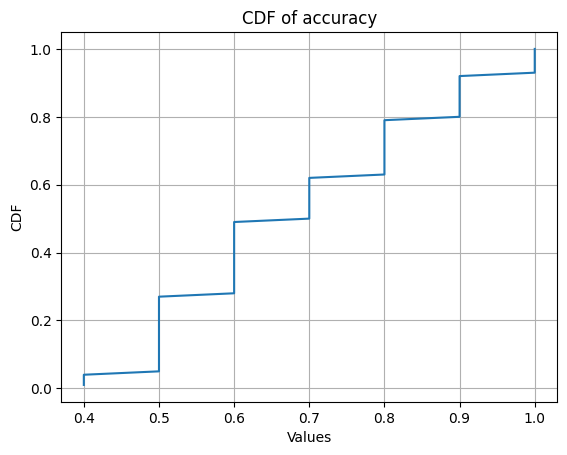

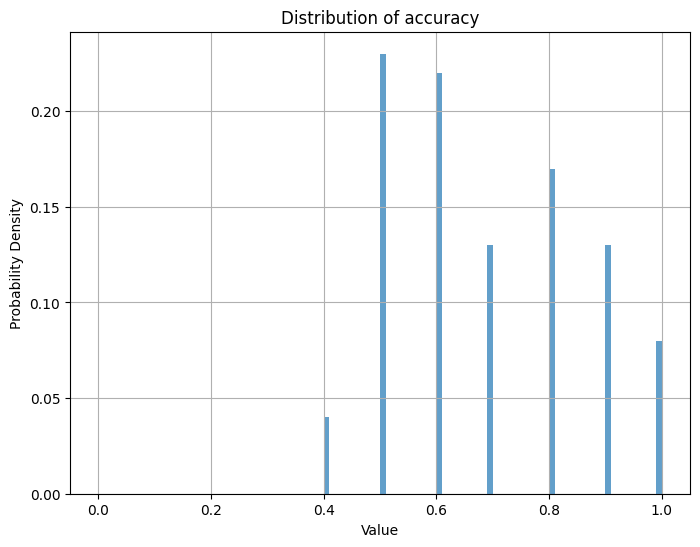

In [ ]:
accuracy = get_binary_accuracy(binary_preds, plot_cdf=True, plot_distribution=True)

In [ ]:
accuracy_descs = get_accuracy_descs(json_data_binary, include_pos_neg=True, display=True)

(0.4, 0.0, 0.8, 'dates or time-related information')
(0.4, 0.6, 0.2, 'words signaling conflicting or contrasting information')
(0.4, 0.0, 0.8, 'phrases related to legal issues and law enforcement')
(0.4, 0.0, 0.8, 'phrases that are commonly used in research or formal reports')
(0.5,
 0.0,
 1.0,
 'references to locations or events related to the state of Florida')
(0.5, 0.0, 1.0, 'metaphorical expressions related to success and achievement')
(0.5, 0.0, 1.0, 'numbers and financial terms')
(0.5, 0.2, 0.8, 'disparities between genders or races in various aspects')
(0.5, 0.0, 1.0, 'words related to elements from the periodic table')
(0.5, 0.0, 1.0, 'names of specific computer software or platforms')
(0.5, 0.0, 1.0, 'mentions of specific locations, with a focus on New York City')
(0.5,
 0.2,
 0.8,
 'instances where something is considered problematic or controversial')
(0.5, 0.0, 1.0, 'references to email sharing')
(0.5,
 0.0,
 1.0,
 'attributes related to products such as being inexpensive,

In [2]:
resave_organized_modeldata(autoencoder_layers = [6],
                        autoencoder_bases = [
                            'neurons',
                            'res-jb',])

gpt2-small/6/1248-1280.json
gpt2-small/6/1088-1120.json
gpt2-small/6/1056-1088.json
gpt2-small/6/192-224.json
gpt2-small/6/1312-1344.json
gpt2-small/6/608-640.json
gpt2-small/6/2624-2656.json
gpt2-small/6/224-256.json
gpt2-small/6/2720-2752.json
gpt2-small/6/1568-1600.json
gpt2-small/6/2240-2272.json
gpt2-small/6/960-992.json
gpt2-small/6/480-512.json
gpt2-small/6/2752-2784.json
gpt2-small/6/3008-3040.json
gpt2-small/6/128-160.json
gpt2-small/6/1504-1536.json
gpt2-small/6/2880-2912.json
gpt2-small/6/448-480.json
gpt2-small/6/2592-2624.json
gpt2-small/6/2976-3008.json
gpt2-small/6/2816-2848.json
gpt2-small/6/2944-2976.json
gpt2-small/6/1472-1504.json
gpt2-small/6/1824-1856.json
gpt2-small/6/1792-1824.json
gpt2-small/6/992-1024.json
gpt2-small/6/672-704.json
gpt2-small/6/1952-1984.json
gpt2-small/6/1920-1952.json
gpt2-small/6/1184-1216.json
gpt2-small/6/352-384.json
gpt2-small/6/160-192.json
gpt2-small/6/704-736.json
gpt2-small/6/2112-2144.json
gpt2-small/6/864-896.json
gpt2-small/6/928-